In [14]:
import pandas as pd
df1 = pd.read_csv('/Users/difa/Desktop/round-1-island-data-bottle/prices_round_1_day_-2.csv', sep =';')
df2 = pd.read_csv('/Users/difa/Desktop/round-1-island-data-bottle/prices_round_1_day_-1.csv', sep =';')
df3 = pd.read_csv('/Users/difa/Desktop/round-1-island-data-bottle/prices_round_1_day_0.csv', sep =';')
combined_df = pd.concat([df1, df2, df3], ignore_index=True)
df_cleaned = combined_df.sort_values(by=['day', 'timestamp']).reset_index(drop=True)


In [15]:
df_cleaned.head()

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
4,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0


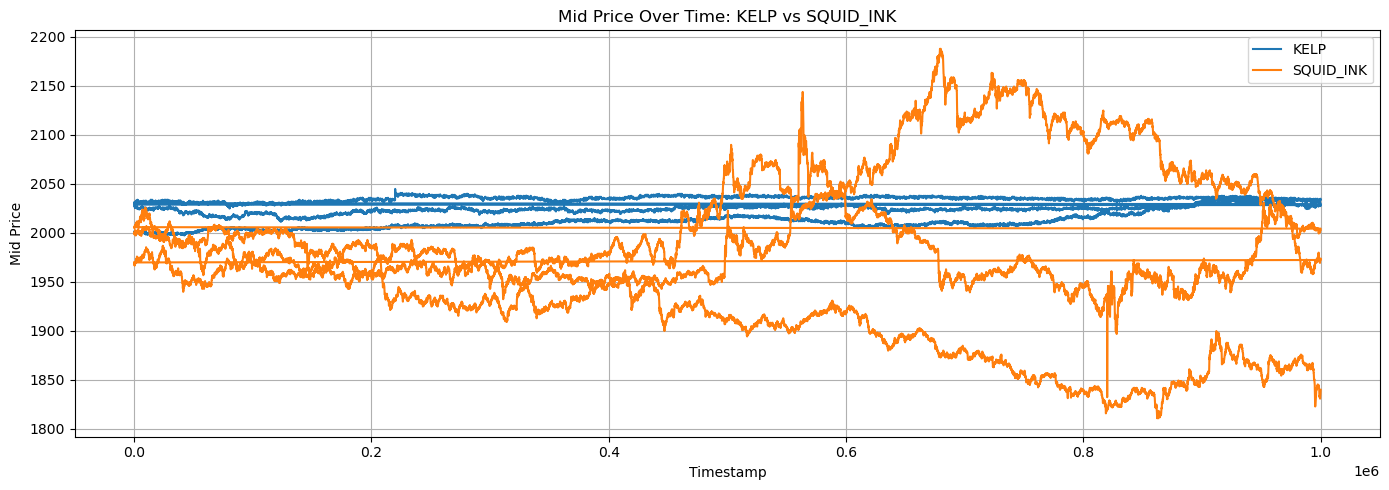

In [18]:
import matplotlib.pyplot as plt

# Filter the dfdata for KELP and SQUID_INK
df_kelp = df_cleaned[df_cleaned["product"] == "KELP"].copy()
df_squid = df_cleaned[df_cleaned["product"] == "SQUID_INK"].copy()

# Plot mid prices over time
plt.figure(figsize=(14, 5))
plt.plot(df_kelp["timestamp"], df_kelp["mid_price"], label="KELP")
plt.plot(df_squid["timestamp"], df_squid["mid_price"], label="SQUID_INK")
plt.title("Mid Price Over Time: KELP vs SQUID_INK")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




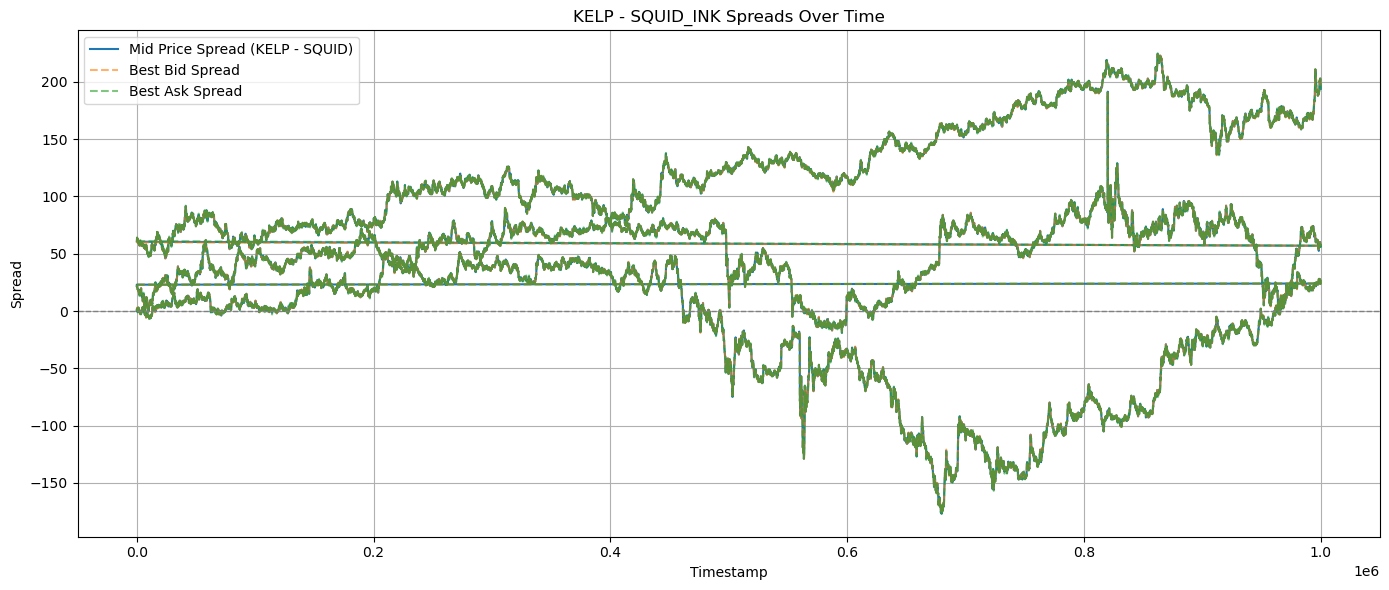

In [19]:
# We'll calculate the spread between KELP and SQUID mid prices
spread_mid = df_kelp.set_index("timestamp")["mid_price"] - df_squid.set_index("timestamp")["mid_price"]
spread_mid.name = "spread_mid"

# Calculate best-bid and best-ask spread differences
kelp_best_bid = df_kelp.set_index("timestamp")["bid_price_1"]
kelp_best_ask = df_kelp.set_index("timestamp")["ask_price_1"]
squid_best_bid = df_squid.set_index("timestamp")["bid_price_1"]
squid_best_ask = df_squid.set_index("timestamp")["ask_price_1"]

spread_bid = kelp_best_bid - squid_best_bid
spread_ask = kelp_best_ask - squid_best_ask

# Combine and plot
plt.figure(figsize=(14, 6))
plt.plot(spread_mid.index, spread_mid, label="Mid Price Spread (KELP - SQUID)")
plt.plot(spread_bid.index, spread_bid, linestyle='--', alpha=0.6, label="Best Bid Spread")
plt.plot(spread_ask.index, spread_ask, linestyle='--', alpha=0.6, label="Best Ask Spread")
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title("KELP - SQUID_INK Spreads Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


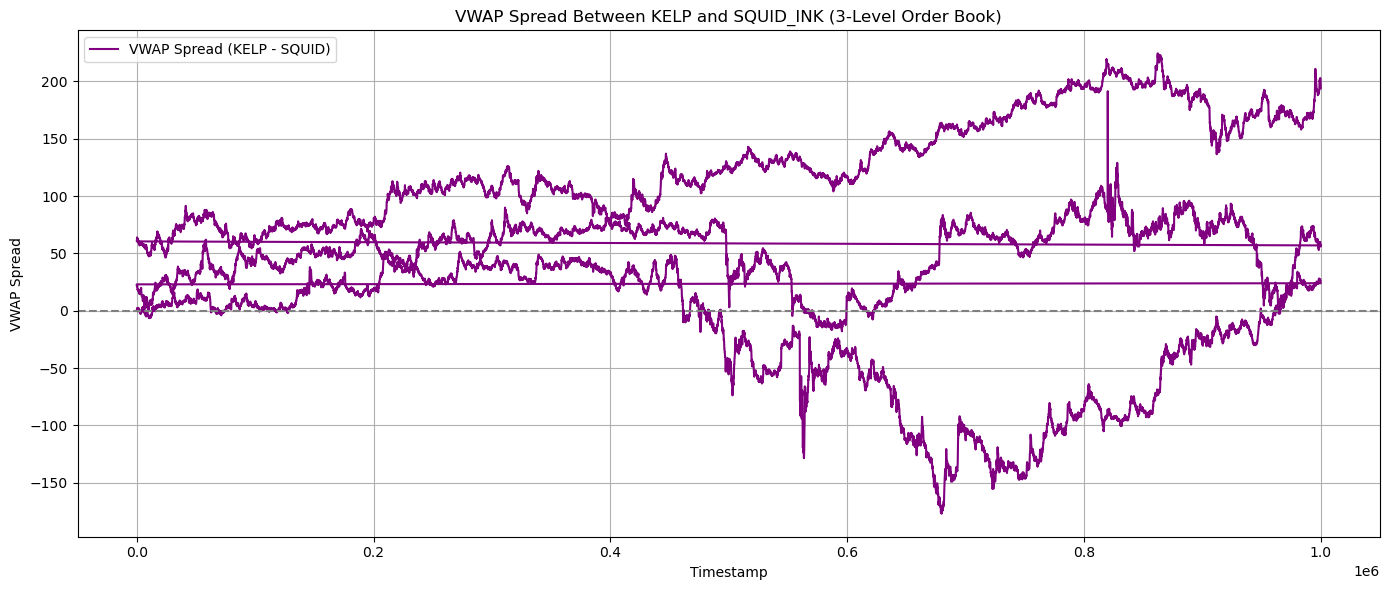

In [21]:
# Build a more complete synthetic price spread estimator using volume-weighted mid-price (VWAP) at best 3 levels
import numpy as np
def vwap_price(bid_prices, bid_vols, ask_prices, ask_vols):
    bid_vwap = np.nansum(np.array(bid_prices) * np.array(bid_vols)) / (np.nansum(bid_vols) + 1e-6)
    ask_vwap = np.nansum(np.array(ask_prices) * np.array(ask_vols)) / (np.nansum(ask_vols) + 1e-6)
    return (bid_vwap + ask_vwap) / 2

# Calculate VWAP-based synthetic mid-price for both assets
kelp_vwap = []
squid_vwap = []

for i in range(len(df_kelp)):
    kelp_row = df_kelp.iloc[i]
    squid_row = df_squid.iloc[i]
    
    kelp_bid_prices = [kelp_row["bid_price_1"], kelp_row["bid_price_2"], kelp_row["bid_price_3"]]
    kelp_bid_vols = [kelp_row["bid_volume_1"], kelp_row["bid_volume_2"], kelp_row["bid_volume_3"]]
    kelp_ask_prices = [kelp_row["ask_price_1"], kelp_row["ask_price_2"], kelp_row["ask_price_3"]]
    kelp_ask_vols = [kelp_row["ask_volume_1"], kelp_row["ask_volume_2"], kelp_row["ask_volume_3"]]

    squid_bid_prices = [squid_row["bid_price_1"], squid_row["bid_price_2"], squid_row["bid_price_3"]]
    squid_bid_vols = [squid_row["bid_volume_1"], squid_row["bid_volume_2"], squid_row["bid_volume_3"]]
    squid_ask_prices = [squid_row["ask_price_1"], squid_row["ask_price_2"], squid_row["ask_price_3"]]
    squid_ask_vols = [squid_row["ask_volume_1"], squid_row["ask_volume_2"], squid_row["ask_volume_3"]]

    kelp_vwap.append(vwap_price(kelp_bid_prices, kelp_bid_vols, kelp_ask_prices, kelp_ask_vols))
    squid_vwap.append(vwap_price(squid_bid_prices, squid_bid_vols, squid_ask_prices, squid_ask_vols))

# Compute VWAP spread
spread_vwap = np.array(kelp_vwap) - np.array(squid_vwap)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_kelp["timestamp"], spread_vwap, label="VWAP Spread (KELP - SQUID)", color="purple")
plt.axhline(0, color='gray', linestyle='--')
plt.title("VWAP Spread Between KELP and SQUID_INK (3-Level Order Book)")
plt.xlabel("Timestamp")
plt.ylabel("VWAP Spread")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


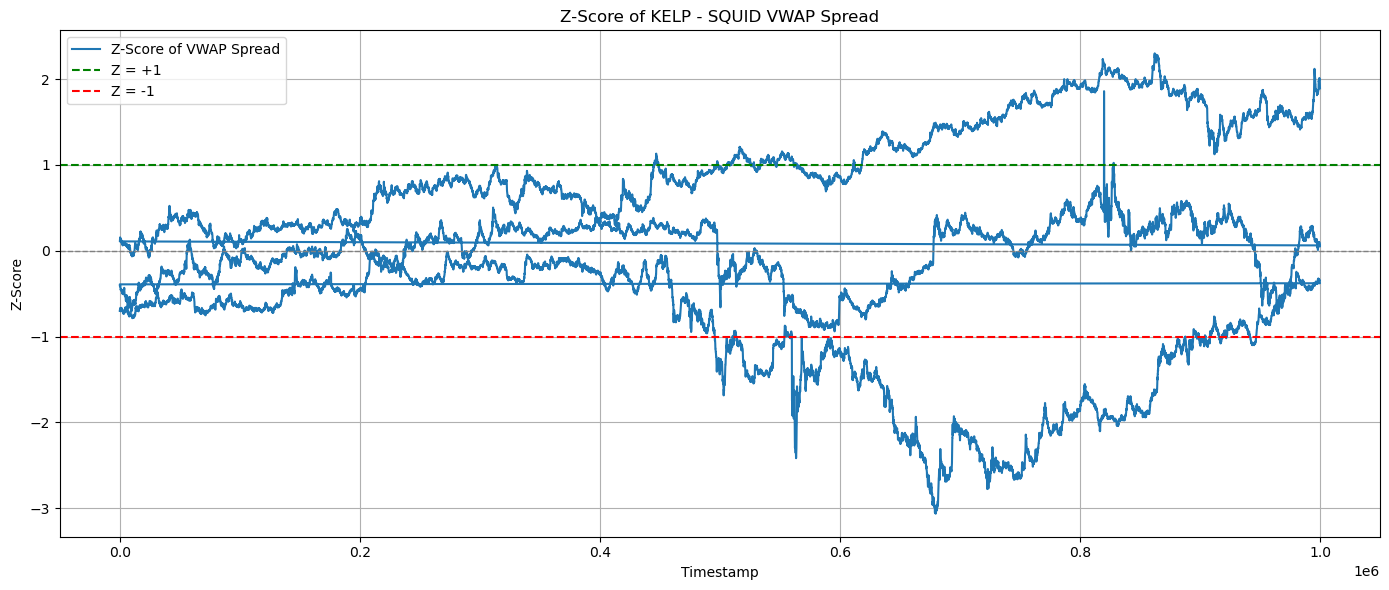

In [23]:
# Step 1: Z-score normalization of the VWAP spread
from scipy.stats import zscore

# Convert VWAP spread to a pandas Series with proper timestamp index
spread_series = pd.Series(spread_vwap, index=df_kelp["timestamp"])
z_spread = zscore(spread_series)

# Step 2: Plot the z-score of the spread
plt.figure(figsize=(14, 6))
plt.plot(df_kelp["timestamp"], z_spread, label="Z-Score of VWAP Spread")
plt.axhline(1, color="green", linestyle="--", label="Z = +1")
plt.axhline(-1, color="red", linestyle="--", label="Z = -1")
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.title("Z-Score of KELP - SQUID VWAP Spread")
plt.xlabel("Timestamp")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



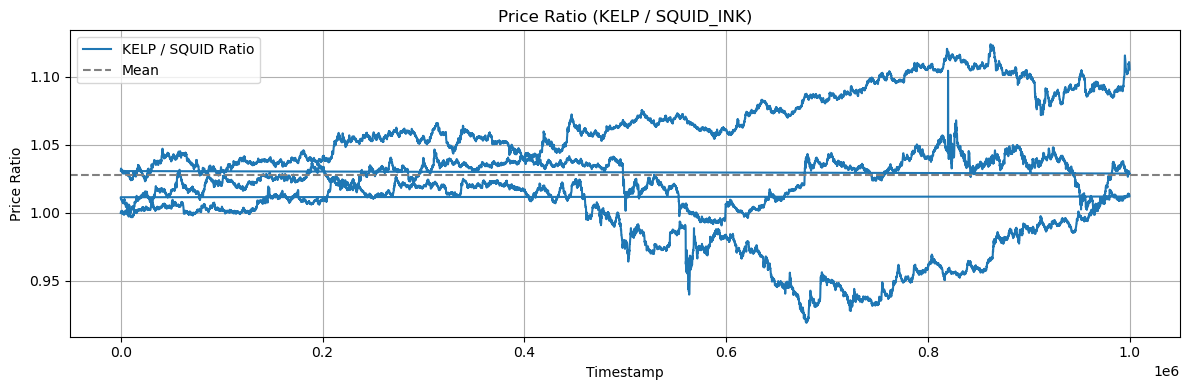

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
kelp_mid = df_kelp["mid_price"].values
squid_mid = df_squid["mid_price"].values
price_ratio = kelp_mid / squid_mid

plt.figure(figsize=(12, 4))
plt.plot(df_kelp["timestamp"], price_ratio, label="KELP / SQUID Ratio")
plt.axhline(np.mean(price_ratio), color='gray', linestyle='--', label="Mean")
plt.title("Price Ratio (KELP / SQUID_INK)")
plt.xlabel("Timestamp")
plt.ylabel("Price Ratio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


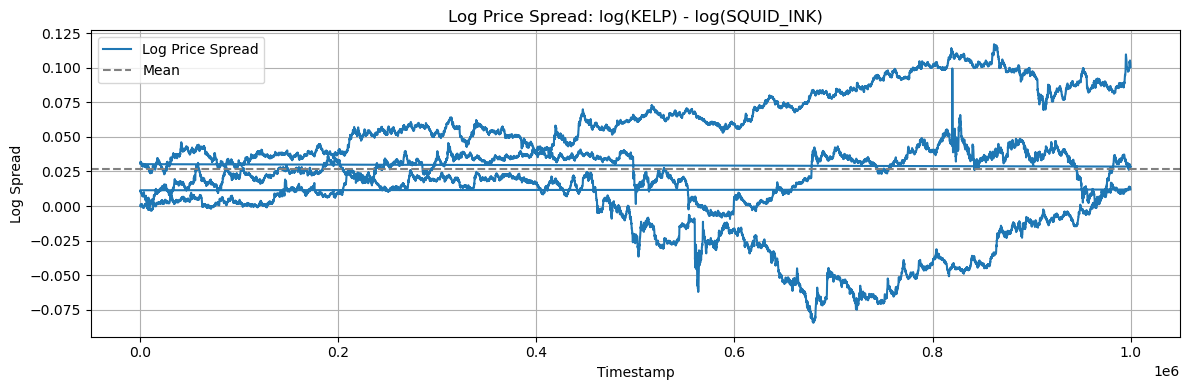

In [25]:
log_spread = np.log(kelp_mid + 1e-6) - np.log(squid_mid + 1e-6)

plt.figure(figsize=(12, 4))
plt.plot(df_kelp["timestamp"], log_spread, label="Log Price Spread")
plt.axhline(np.mean(log_spread), color='gray', linestyle='--', label="Mean")
plt.title("Log Price Spread: log(KELP) - log(SQUID_INK)")
plt.xlabel("Timestamp")
plt.ylabel("Log Spread")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


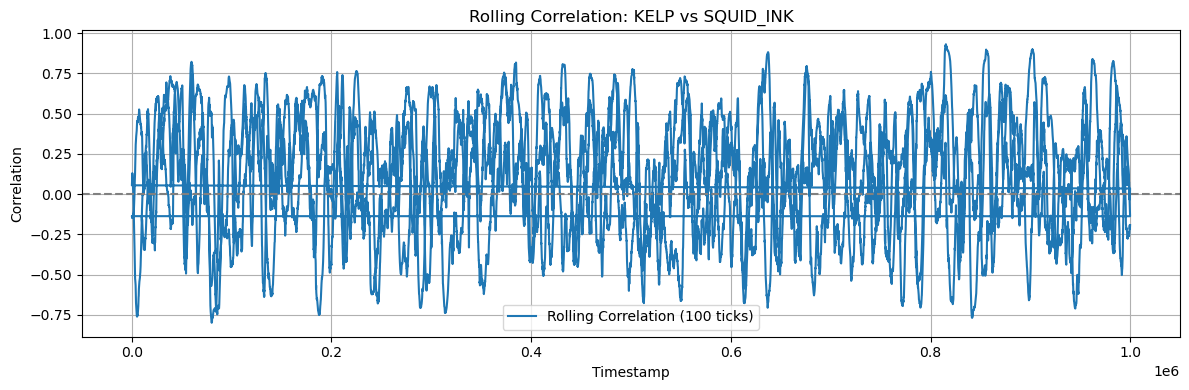

In [26]:
rolling_corr = pd.Series(kelp_mid).rolling(100).corr(pd.Series(squid_mid))

plt.figure(figsize=(12, 4))
plt.plot(df_kelp["timestamp"], rolling_corr, label="Rolling Correlation (100 ticks)")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Rolling Correlation: KELP vs SQUID_INK")
plt.xlabel("Timestamp")
plt.ylabel("Correlation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
print("ADF Test on Raw Spread (kelp - squid):")
print(adfuller(kelp_mid - squid_mid))

print("\nADF Test on Log Spread:")
print(adfuller(log_spread))

print("\nADF Test on Price Ratio:")
print(adfuller(price_ratio))


ADF Test on Raw Spread (kelp - squid):
(-1.2225502651991158, 0.6638207189664939, 41, 29958, {'1%': -3.4305683009682313, '5%': -2.861636483122232, '10%': -2.5668213550225185}, 116869.76705757956)

ADF Test on Log Spread:
(-1.1713741685160086, 0.6857870451666142, 41, 29958, {'1%': -3.4305683009682313, '5%': -2.861636483122232, '10%': -2.5668213550225185}, -337683.51798509667)

ADF Test on Price Ratio:
(-1.1120754997040114, 0.7102323897734532, 41, 29958, {'1%': -3.4305683009682313, '5%': -2.861636483122232, '10%': -2.5668213550225185}, -336009.1160788607)


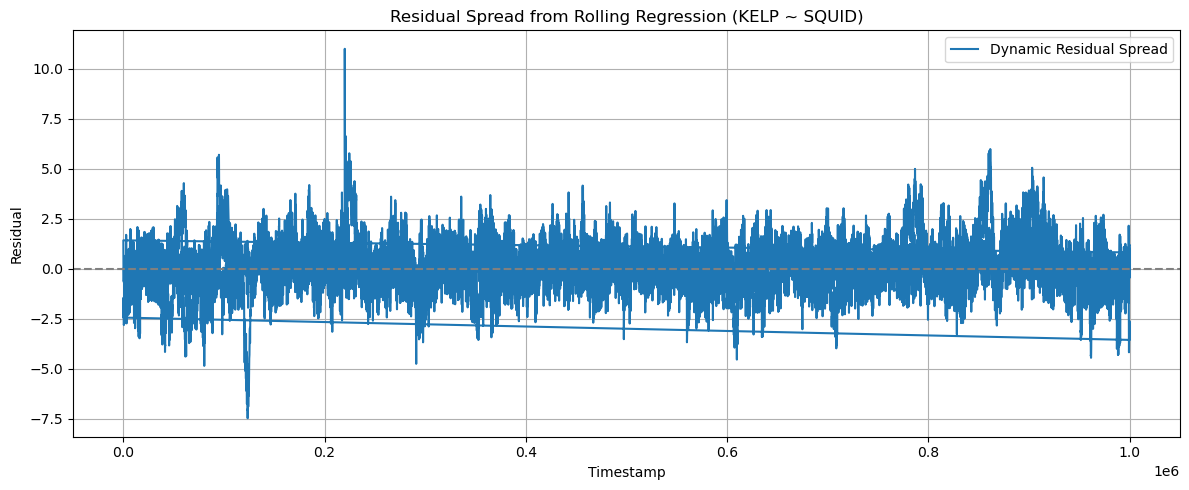

ADF Test on Residual Spread:
(-16.96015810777324, 9.321374750145543e-30, 9, 29791, {'1%': -3.4305695248077694, '5%': -2.8616370240061957, '10%': -2.5668216429220307}, 56778.61002029099)


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm

# Ensure numpy arrays
kelp_mid = df_kelp["mid_price"].values
squid_mid = df_squid["mid_price"].values

# Build DataFrame
spread_df = pd.DataFrame({
    "kelp": kelp_mid,
    "squid": squid_mid
})

# Add constant for regression intercept
spread_df["const"] = 1

# Rolling regression to get dynamic hedge ratio (beta)
rolling_window = 200
model = RollingOLS(spread_df["kelp"], sm.add_constant(spread_df["squid"]), window=rolling_window)
rres = model.fit()

# Extract dynamic beta (slope) and alpha (intercept)
spread_df["beta"] = rres.params["squid"]
spread_df["alpha"] = rres.params["const"]

# Compute dynamic residual: KELP - (alpha + beta * SQUID)
spread_df["residual"] = spread_df["kelp"] - (spread_df["alpha"] + spread_df["beta"] * spread_df["squid"])

# Plot residual spread
plt.figure(figsize=(12, 5))
plt.plot(df_kelp["timestamp"], spread_df["residual"], label="Dynamic Residual Spread")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Residual Spread from Rolling Regression (KELP ~ SQUID)")
plt.xlabel("Timestamp")
plt.ylabel("Residual")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# ADF test on residual
residual_clean = spread_df["residual"].dropna()
print("ADF Test on Residual Spread:")
print(adfuller(residual_clean))
